**Google translated task** (original is on Russian):

We own a chain of stores that sell various products. Our employees collected a dataset of 8523 sales of products in various stores in our network. Our goal is to build a model that predicts the sales of each product in a particular store. Using this model, try to identify the factors that most affect the increase in sales. Description of the dataset:

The result should be:
* Jupyter-laptop with model
* Signs that affect the sales level the most
* Dataset, if it differs from the original one after your manipulations;
* Document with justification of the decision and brief results: what techniques were used and why, what they received, what can be improved (you can use jupyter Notepad)

As usual, I will comment my work on English.

# Exploratory Data Analysis

In [190]:
import pandas as pd
from pandas_profiling import ProfileReport
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import mplcyberpunk

import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from stacking import StackModel

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import math

import pickle

In [134]:
data = pd.read_csv('data.csv')

In [135]:
data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


So, we have 12 columns, eleven of which are potential features. The last field (Item_Outlet_Sales) is the target field. 

We have 7 categorical fields and 4 continuous (excluding target field).

I want to know, how many items do we have.

In [136]:
data['Item_Identifier'].unique().shape

(1559,)

A lot of. They repeat only for different outlets. I am not sure do I want this as a feature.

# Fill NaN values
First let's find all columns that have NaN values.

In [137]:
# NA finder
na = {}


def find_na(row):
    global na
    for key in row.keys():
        if pd.isna(row[key]):
            if key in na:
                na[key] += 1
            else:
                na[key] = 1


data.apply(find_na, axis=1)
print(na)

{'Outlet_Size': 2410, 'Item_Weight': 1463}


Only two fields have NaN values. I will treat Outlet_Size first.

## Outlet Size

We have at least two fields that can help us to predict outlet size:
* Outlet_Type
* Outlet_Location_Type

But maybe this is simpler. And in fact we do have outlet size based on outlet indentifier. Let's check this first. 

In [138]:
data['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT046    930
OUT035    930
OUT049    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

10 stores total. Find size for each.

In [139]:
sizes = {}

def size_check(row):
    global sizes
    
    if row['Outlet_Identifier'] in sizes:
        if sizes[row['Outlet_Identifier']] == 0:
            sizes[row['Outlet_Identifier']] = row['Outlet_Size']
    else:
        if pd.isna(row['Outlet_Size']):
            sizes[row['Outlet_Identifier']] = 0
        else:
            sizes[row['Outlet_Identifier']] = row['Outlet_Size']


data.apply(size_check, axis=1)
sizes

{'OUT049': 'Medium',
 'OUT018': 'Medium',
 'OUT010': nan,
 'OUT013': 'High',
 'OUT027': 'Medium',
 'OUT045': nan,
 'OUT017': nan,
 'OUT046': 'Small',
 'OUT035': 'Small',
 'OUT019': 'Small'}

My plan did not work. Ok, then I should return to the first idea and find sizes of OUT010, OUT017 and OUT045.

In [140]:
data[['Outlet_Identifier','Outlet_Location_Type', 'Outlet_Type', 'Outlet_Size']].drop_duplicates()

,Outlet_Identifier,Outlet_Location_Type,Outlet_Type,Outlet_Size
0,OUT049,Tier 1,Supermarket Type1,Medium
1,OUT018,Tier 3,Supermarket Type2,Medium
3,OUT010,Tier 3,Grocery Store,NaN
4,OUT013,Tier 3,Supermarket Type1,High
7,OUT027,Tier 3,Supermarket Type3,Medium
8,OUT045,Tier 2,Supermarket Type1,NaN
9,OUT017,Tier 2,Supermarket Type1,NaN
11,OUT046,Tier 1,Supermarket Type1,Small
19,OUT035,Tier 2,Supermarket Type1,Small
23,OUT019,Tier 1,Grocery Store,Small


My strategy is to take the most common outlet size with the same location and outlet type. There are not a lot of outlets, so the method is super simple.
* For out045 and out017 the only suitable outlet is out035 and it has small size
* For out010, unfortunately, there is no similar outlet, and I will prioritize outlet type over location type because I consider type more important for size choice. This why its size will be as the size of OUT019 - small.

Of course, my strategy is far from perfect, as you can see, it fails even on known outlet size. But I think there is no better option with only 10 records related to outlets themselves.

In [141]:
outlets = ['OUT010', 'OUT045', 'OUT017']

def set_size(row):
    global outlets
    
    if row['Outlet_Identifier'] in outlets:
        return 'Small'
    else:
        return row['Outlet_Size']


data['Outlet_Size'] = data.apply(set_size, axis=1)

## Item Weight

Item weight is continuous metric. I will try to predict it based on median for all items of one type.

In [142]:
data['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [143]:
# get median weight for every item type
item_weight = data[['Item_Type', 'Item_Weight']].groupby('Item_Type').agg(pd.Series.median)

# transform it to dictionary
item_weight = item_weight.to_dict()['Item_Weight']

In [144]:
def iw(row):
    global item_weight
    
    if pd.isna(row['Item_Weight']):
        return item_weight[row['Item_Type']]
    else:
        return row['Item_Weight']

data['Item_Weight'] = data.apply(iw, axis=1)

In [145]:
na = {}
data.apply(find_na, axis=1)
print(na)

{}


**No more unknown values.**

# Scaling
Scale continuous features.

In [146]:
# list of continuous features
cf = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']
scaler = MinMaxScaler()
data[cf] = scaler.fit_transform(data[cf])

# Categorical features

The task assumes using of several different models. This is why the most universal method to work with categorical features is one hot encoding.

I will for split data in datasets:
* full
* without Item_Identifier

In [147]:
def ohe(data, cols):
    for col in cols:
        data = pd.concat([data, pd.get_dummies(data[col], prefix=col)], axis=1)
        del(data[col])
    
    return data

In [148]:
no_item_id = data.copy()
del(no_item_id['Item_Identifier'])
cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Location_Type', 'Outlet_Type', 'Outlet_Size']
no_item_id = ohe(no_item_id, cols)

In [149]:
no_item_id

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small
0,0.282525,0.048866,0.927507,0.583333,3735.1380,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0
1,0.081274,0.058705,0.072068,1.000000,443.4228,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
2,0.770765,0.051037,0.468288,0.583333,2097.2700,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0
3,0.871986,0.000000,0.640093,0.541667,732.3800,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1
4,0.260494,0.000000,0.095805,0.083333,994.7052,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,0.137541,0.172914,0.777729,0.083333,2778.3834,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
8519,0.227746,0.143069,0.326263,0.708333,549.2850,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1
8520,0.359929,0.107148,0.228492,0.791667,1193.1136,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1
8521,0.158083,0.442219,0.304939,1.000000,1845.5976,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0


In [150]:
# columns for one hot encoding
cols = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Location_Type', 'Outlet_Type', 'Outlet_Size']
data = ohe(data, cols)

# Correlation

In [151]:
# I don't see a way to use ProfileReport on full dataset, so I use dataset without Item Identifier
# ProfileReport(no_item_id)

I am getting error "ValueError: Wrong number of items passed 39, placement implies 37" on this. The error has its branch on GitHub https://github.com/pandas-profiling/pandas-profiling/issues/270 but unfortunately still no answer or solution other than just remove "bad" feature from the report. I find my own weird solution for this :)

In [152]:
# BRUTE FORCE ProfileReport
worked = False
for i in range(100):
    try:
        pr = ProfileReport(no_item_id)
        print('Finally worked')
        worked = True
        break
    except ValueError:
        continue

Finally worked


In [153]:
if worked:
    pr.to_widgets()
else:
    print('Unfortunately, the hack didn\'t worked. Please, run again the previous cell if you really need a report.')

Probably not worth it. After all, i did ProfileReport mainly for correlation matrix. But it is too tiny to see anything there. Let's do it another way.

In [154]:
correlation = no_item_id.corr()

In [155]:
correlation

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_LF,Item_Fat_Content_Low_Fat,Item_Fat_Content_Regular,Item_Fat_Content_low_fat,Item_Fat_Content_reg,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier_1,Outlet_Location_Type_Tier_2,Outlet_Location_Type_Tier_3,Outlet_Type_Grocery_Store,Outlet_Type_Supermarket_Type1,Outlet_Type_Supermarket_Type2,Outlet_Type_Supermarket_Type3,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small
Item_Weight,1.000000,-0.013384,0.026537,0.007724,0.010188,-0.002543,0.023506,-0.021553,-0.008047,0.000601,-0.043603,-0.065975,-0.011889,-0.036153,0.041705,0.004012,0.037782,-0.060598,0.009447,0.043401,-0.005013,0.038981,-0.009105,0.019388,-0.053874,0.025533,0.006208,0.015925,0.001093,0.004942,-0.011444,-0.018831,0.001317,-0.013475,0.004407,0.008587,0.002878,-0.007353,0.004414,-0.003684,0.011718,0.004942,-0.018831,0.015925,-0.003555,-0.006656
Item_Visibility,-0.013384,1.000000,-0.001315,-0.074834,-0.128625,0.001885,-0.046386,0.047631,-0.001860,0.000523,0.016887,0.000416,0.043418,0.011114,0.035984,-0.003153,0.018969,-0.003700,-0.053931,-0.032230,-0.017087,-0.016240,0.014910,0.005635,-0.009825,0.003688,0.180697,-0.041937,-0.032179,-0.034671,0.210736,-0.051144,-0.033025,-0.038353,-0.038444,-0.036130,0.061346,-0.068787,0.009650,0.286400,-0.144249,-0.034671,-0.051144,-0.041937,-0.081061,0.103092
Item_MRP,0.026537,-0.001315,1.000000,0.005020,0.567574,-0.006947,-0.000466,0.008299,-0.011904,-0.008865,-0.067311,-0.000112,0.001460,-0.005666,0.035551,-0.013358,0.023688,-0.010089,-0.041646,0.046815,-0.004086,-0.018595,0.001186,0.033817,-0.035808,0.014613,-0.000912,0.002438,-0.008812,0.003850,-0.004976,-0.006714,0.011969,-0.000239,0.005983,-0.003906,-0.001229,0.001951,-0.000744,-0.004277,0.004885,0.003850,-0.006714,0.002438,-0.004510,0.002734
Outlet_Establishment_Year,0.007724,-0.074834,0.005020,1.000000,-0.049135,0.002458,0.002218,-0.002051,-0.026852,0.021281,-0.003546,-0.003631,-0.006768,0.010998,-0.005286,0.007690,-0.005495,0.006627,-0.002961,-0.001951,-0.013428,-0.002874,-0.001013,0.002650,0.007486,0.011897,0.005301,-0.453388,0.382361,0.466336,-0.393918,-0.538072,0.257868,0.174150,-0.034777,0.048836,-0.201690,0.540820,-0.333895,-0.281196,0.245070,0.466336,-0.538072,-0.453388,-0.016346,0.300724
Item_Outlet_Sales,0.010188,-0.128625,0.567574,-0.049135,1.000000,-0.012389,-0.011993,0.022618,-0.006326,-0.015148,-0.038381,0.002332,-0.004656,0.007387,0.008858,-0.009482,0.025950,-0.003956,-0.025587,0.015701,-0.002995,-0.021267,0.007380,0.022782,-0.024040,0.015039,-0.284883,0.024170,0.032610,-0.038059,-0.277250,0.311192,0.052823,0.002274,0.019803,0.034264,-0.111287,0.058261,0.046376,-0.411727,0.108765,-0.038059,0.311192,0.024170,0.204701,-0.208912
Item_Fat_Content_LF,-0.002543,0.001885,-0.006947,0.002458,-0.012389,1.000000,-0.238873,-0.140513,-0.022643,-0.023150,-0.009431,-0.004797,-0.011434,-0.016534,-0.002943,-0.020116,-0.011792,0.000261,0.025218,0.040739,-0.016425,0.021087,0.011704,-0.024087,0.032104,0.016699,0.013648,-0.005084,-0.006650,0.015137,-0.001484,0.004637,0.007009,-0.016825,0.009001,-0.016891,-0.006275,-0.010932,0.016267,0.009036,-0.019290,0.015137,0.004637,-0.005084,0.001913,0.001388
Item_Fat_Content_Low_Fat,0.023506,-0.046386,-0.000466,0.002218,-0.011993,-0.238873,1.000000,-0.871729,-0.140476,-0.143620,-0.077541,-0.033774,-0.056544,-0.066300,-0.022231,-0.069325,-0.105859,0.108896,0.170414,0.229783,-0.104144,0.094

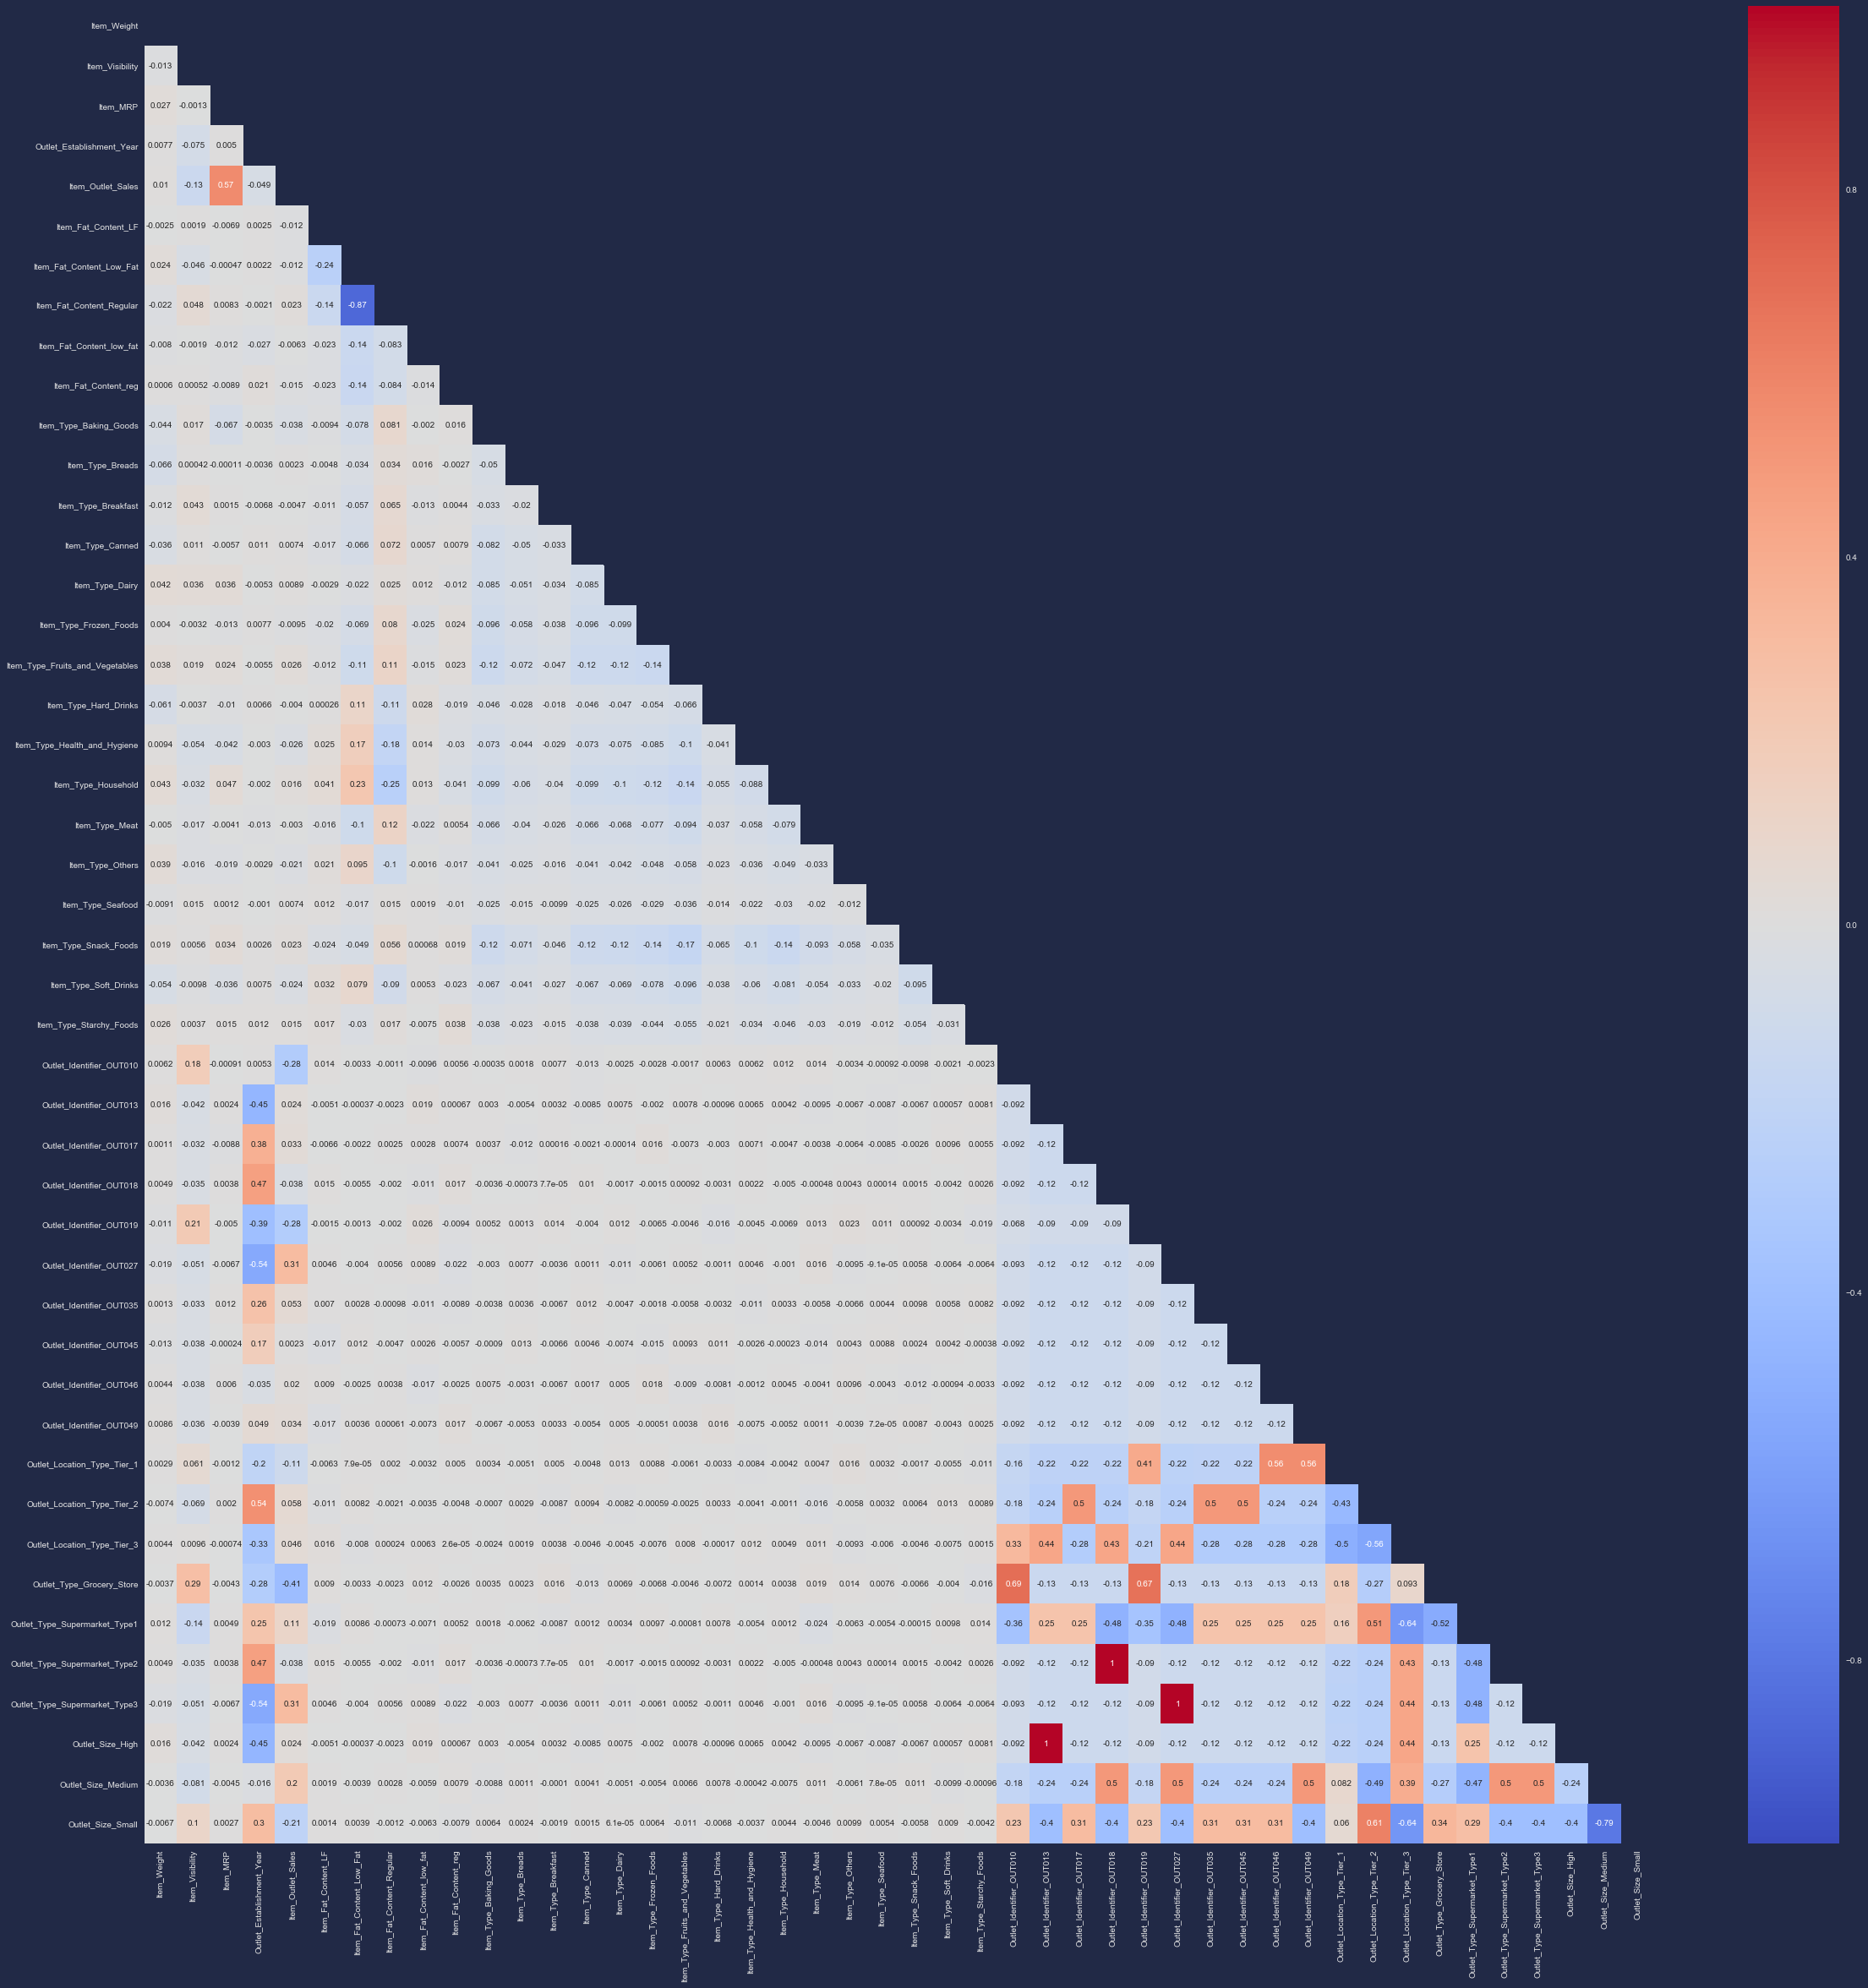

In [156]:
rcParams['figure.figsize'] = 40, 40
matrix = np.triu(correlation)
sns.heatmap(correlation, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix)

# code to fix seaborn heatmap crop. Not my, unfortunately :) 
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

# I will explore the correlation matrix using an image file. Unfortunately, jupyter notebook can't scale too much
plt.savefig('correlation')
plt.show() 

**Positive Correlation:**
* Item_Outlet_Sales and Item_MPR. Well, it's understandable. The more an item costs, the more money it will bring. Of course, this can be balanced by the quantitative of cheap items sold. But here the situation is different.
* Best type of outlet for sales is "supermarket type 3"

**Negative Correlation:**
* Item_Fat_Content = Regular and Item_Fat_Content = Low fat. Ok, this one I don't really get. No, no, I understand that "regular" is not "low", but why this true only for these two variables? Who knows...
* Outlet Type = Grocery Store and Sales. I don't know exaclty what is the difference between type of stores. Probably Grocery Store is not good for sales :) 

**General:**
* Establishment_Year correlates to outlets and variables that related to them. This is reasonable because we have only 10 observations.

In [157]:
X = no_item_id.copy()
del(X['Item_Outlet_Sales'])
y = no_item_id['Item_Outlet_Sales']

# How I will score a model?
I like R2 score. It is easy to interpret no matter what data you have. Unlike MSE. But I still will use MSE for additional model scoring. To interpret MSE we should know the mean value of the target:

In [158]:
y.mean()

2181.2889135750365

# Feature importance
Before we take serious steps, I will use RandomForest to evaluate feature importance.

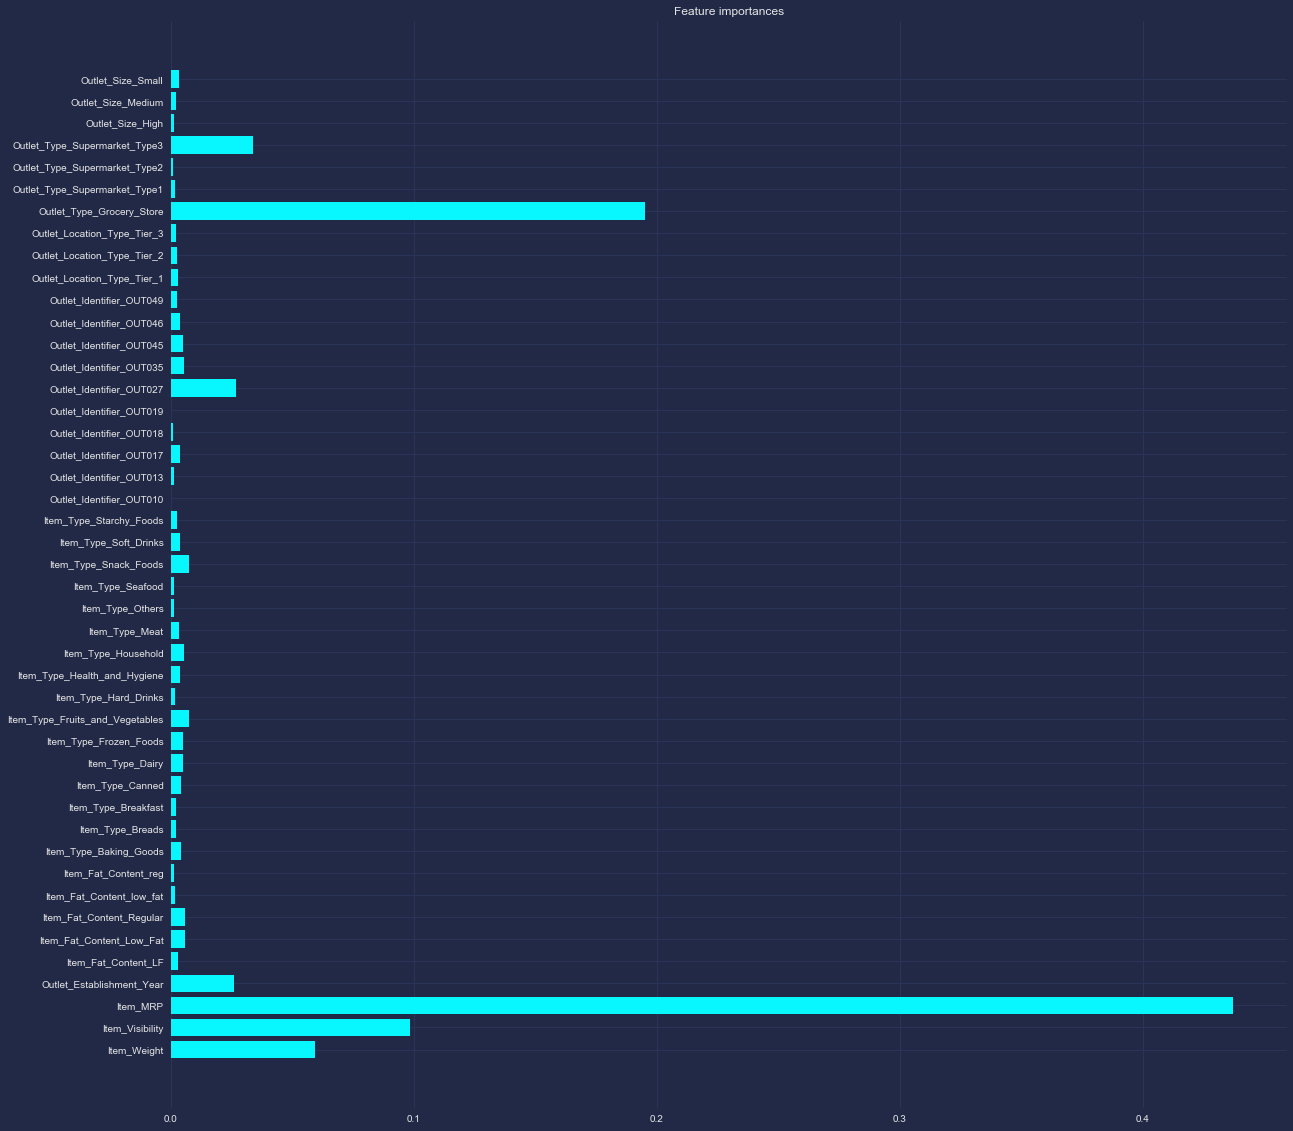

In [159]:
model = RandomForestRegressor()
model.fit(X, y) # I don't split data because this step is only to determining feature importance

importance = model.feature_importances_
rcParams['figure.figsize'] = 20, 20
plt.style.use("cyberpunk")
plt.figure()
plt.title("Feature importances")
plt.barh(X.columns, importance)

plt.show()

Some of my assumptions are confirmed by this chart. The most important feature is the price of an item. As I thought Grocery Store has a strong influence on the target value. But the correlation matrix didn't show the importance of item visibility and weight. Outlet 027 is damn good!

## Top 3 features

* Item_MRP
* Outlet_Type_Grocery_Store
* Item_Visibility

# First prediction
Let's take a look on model results without optimization

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)
p = model.predict(X_test)

print('R2 score: ', r2_score(y_test, p))
print('MSE: ', mean_squared_error(y_test, p))

R2 score:  0.5661747843484601
MSE:  1179123.9502844298


Awful prediction. Now I have motivation to improve results.

# Linear model optimization
Unfortunately, LinearRegression has no hyperparameters. So nothing to optimize. This is why I will use Ridge estimator.

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = Ridge()
model.fit(X_train, y_train)
p = model.predict(X_test)

print('R2 score: ', r2_score(y_test, p))
print('MSE: ', mean_squared_error(y_test, p))

R2 score:  0.5791600393655694
MSE:  1143830.4158405424


Slightly better than RandomForest, but probably it can do even better.

In [191]:
a = list(range(1,100))
alpha = [x/10 for x in a]
#max_iter = list(range(100,10000))
solver = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
param_grid = dict(alpha=alpha, solver=solver)

grid_linear = GridSearchCV(Ridge(), 
                    param_grid=param_grid, 
                    cv=10, 
                    scoring='r2',
                    n_jobs=-1)

grid_linear.fit(X,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8,
                                   1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7,
                                   2.8, 2.9, 3.0, ...],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [164]:
print(grid_linear.best_score_)
print(grid_linear.best_estimator_)

0.5585568414476374
Ridge(alpha=8.3, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='lsqr', tol=0.001)


This is not good. My optimization tries didn't give me any significant improvment. Let's try to increase maximum iterations for best_estimator, maybe this will improve the quality.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = Ridge(alpha=2.1, solver='saga', max_iter=1000000)
model.fit(X_train, y_train)
p = model.predict(X_test)

print('R2 score: ', r2_score(y_test, p))
print('MSE: ', mean_squared_error(y_test, p))

No, it didn't. I am curious what will show classic LinearRegression.

In [ ]:
# to compare models list all coefs of Ridge
model.coef_

In [167]:
model.intercept_

428.5098455136708

In [168]:
model = LinearRegression()
model.fit(X_train, y_train)
p = model.predict(X_test)

print('R2 score: ', r2_score(y_test, p))
print('MSE: ', mean_squared_error(y_test, p))

R2 score:  0.5791022043663115
MSE:  1143987.6096373277


In [171]:
model.coef_

array([-3.41250406e+01, -1.55724840e+02,  3.68937336e+03, -8.36836483e+14,
       -1.03308638e+15, -1.03308638e+15, -1.03308638e+15, -1.03308638e+15,
       -1.03308638e+15,  4.42564003e+14,  4.42564003e+14,  4.42564003e+14,
        4.42564003e+14,  4.42564003e+14,  4.42564003e+14,  4.42564003e+14,
        4.42564003e+14,  4.42564003e+14,  4.42564003e+14,  4.42564003e+14,
        4.42564003e+14,  4.42564003e+14,  4.42564003e+14,  4.42564003e+14,
        4.42564003e+14,  2.36073562e+15, -9.19970464e+14,  1.82695448e+14,
       -3.66565055e+14,  4.80015106e+14, -8.74985497e+14,  7.80908881e+13,
        8.35451449e+12, -3.33820607e+14, -3.69017230e+15, -7.89598606e+14,
       -9.57432794e+14, -2.21703269e+15, -2.20010029e+14,  1.01224393e+15,
       -5.35247370e+14, -8.63663411e+14, -3.62530959e+14,  1.39865504e+15,
       -2.02743304e+15])

In [170]:
model.intercept_

3147548938042145.5

R2 scores are near the same, but I more like Ridge variant, because coefficients and intercept are more suitable.

# Non-linear model optimization
I will use Nearest Neighbors Regression.

In [181]:
n_neighbors = list(range(1,100))
weights = ['uniform', 'distance']
algorithm = ['ball_tree', 'kd_tree'] # I don't use broot force because I will also optimize by leaf size
leaf_size = list(range(10,100))
param_grid = dict(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size)

grid = GridSearchCV(KNeighborsRegressor(), 
                    param_grid=param_grid, 
                    cv=10, 
                    scoring='r2',
                    n_jobs=-1)

grid.fit(X,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'leaf_size': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                       20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                       30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights'

It took almost a day to calculate so I will save it to pickle file.

In [185]:
f = open('nnr_grid.pkl', 'wb')
pickle.dump(grid, f)
f.close()

In [187]:
print(grid.best_score_)
print(grid.best_estimator_)

0.499584094486672
KNeighborsRegressor(algorithm='ball_tree', leaf_size=10, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=14, p=2,
                    weights='distance')


Not good results for a wasted day :) 

# Stacking

In [201]:
models = [DecisionTreeRegressor(), grid.best_estimator_, grid_linear.best_estimator_]
meta = LinearRegression()

stack = StackModel(models, meta)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

stack.fit(X_train, y_train)

p = stack.predict(X_test, y_test)

print('Meta-model R2 score: ', r2_score(y_test, p))

Meta-model R2 score:  0.5779171576754101


In [213]:
math.sqrt(mean_squared_error(y_test, p))

1071.0782095957052

In [194]:
stack.estimators_score

{'DecisionTreeRegressor': 0.1686088402681588,
 'KNeighborsRegressor': 0.5125566048959092,
 'Ridge': 0.5793920818607112}

Surprisingly enough no improvement over the best "weak" estimator.

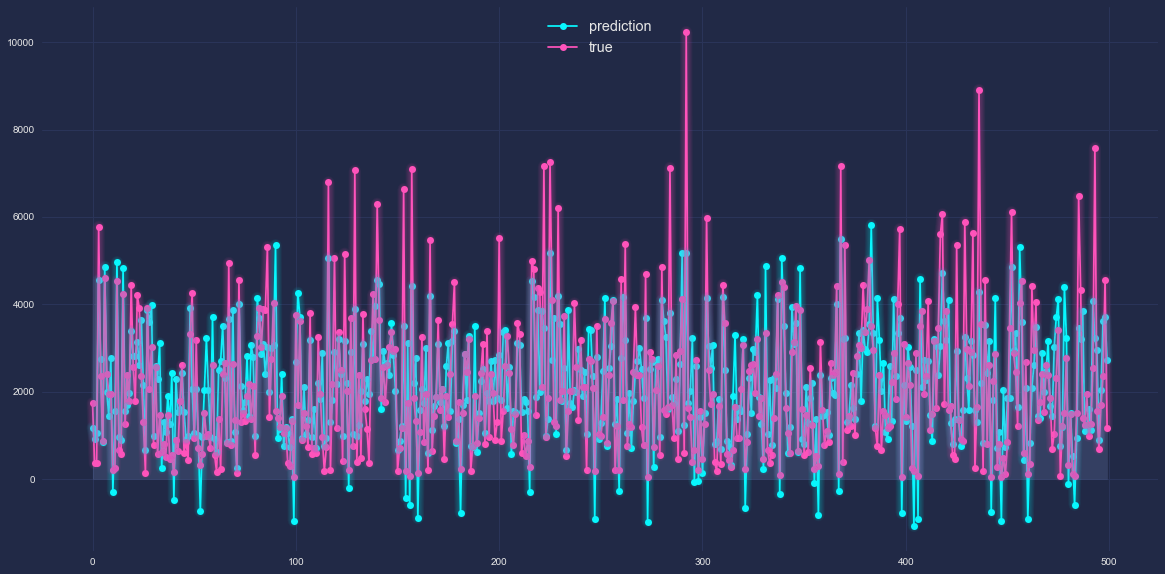

In [211]:
rcParams['figure.figsize'] = 20, 10

fig, ax = plt.subplots()
ax.plot(p[:500], marker='o', label='prediction')
ax.plot(y_test.values[:500], marker='o', label='true')
legend = ax.legend(loc='upper center', fontsize='x-large')

mplcyberpunk.add_glow_effects()

plt.show()

# Full dataset
Maybe we need item id to improve the quality.

In [197]:
X = data.copy()
del(X['Item_Outlet_Sales'])
y = data['Item_Outlet_Sales']

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

p = model.predict(X_test)

print('Full data R2 score: ', r2_score(y_test, p))

Full data R2 score:  0.5594727506199194


Probably even worse. No point to use Item_Identifier.